In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from tqdm.auto import tqdm
import openai

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


In [92]:
# Get connected to Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
#The data files on my Google drive:
file_path_to_save = '/content/drive/My Drive/Colab_Notebooks/csv_saved/'

adverse = pd.read_csv(file_path_to_save+'VAERSDATA_1990_2025_COMBINED.csv')
symptoms = pd.read_csv(file_path_to_save+'VAERSSYMPTOMS_1990_2025_COMBINED.csv')
vax = pd.read_csv(file_path_to_save+'VAERSVAX_1990_2025_COMBINED.csv')

/tmp/ipython-input-93-2255359128.py:4: DtypeWarning: Columns (8,13,16,24,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  adverse = pd.read_csv(file_path_to_save+'VAERSDATA_1990_2025_COMBINED.csv')


According to the paper, [Vaccines and sudden infant death: An analysis of the VAERS database 1990–2019 and review of the medical literature](https://www.sciencedirect.com/science/article/pii/S2214750021001268), an online search of the VAERS database was conducted. The database was filtered to only include reports with a vaccination date from 1990 through 2019, of infants (children < 1 year of age) who died within 60 days post-vaccination.

Here, we reconstruct the study and check its statistics.
First, we filter by the years (from 1990 through 2019), then by age (children < 1 year of age), and then by date of death (within 60 days post-vaccination).
In the paper, they mention that there are 2605 such deaths; however, when we filter the data accordingly, we only get 2527.

Under the Results\Demographic data in the paper, we have: "There were 2989 infant deaths reported to VAERS with a vaccination date from 1990 through 2019. Of this total, 2605 (87.2 %) occurred within 60 days.

However, in our downloaded data from the VAERS website, we have 2802 total infant deaths and of this total, 2527 (90.19%) occured within 60 days. Slightly different numbers but relatively close to the study.


In [94]:
adverse_paper = adverse.copy()

## Filtering by VAX_DATE:
# Convert VAX_DATE to datetime format
adverse_paper['VAX_DATE_DATE'] = pd.to_datetime(adverse_paper['VAX_DATE'], errors='coerce')
# Extract year and assign to new column
adverse_paper['VAX_YEAR'] = adverse_paper['VAX_DATE_DATE'].dt.year
adverse_paper= adverse_paper[(adverse_paper.VAX_YEAR < 2020)]

## Filtering by AGE:
adverse_1 = adverse_paper[adverse_paper.AGE_YRS<=1]

## Filtering by DELTA_DAYS:
adverse_1_d = adverse_1.copy()
adverse_1_d['VAX_DATE_d'] = pd.to_datetime(adverse_1_d['VAX_DATE'])
adverse_1_d['ONSET_DATE_d'] = pd.to_datetime(adverse_1_d['ONSET_DATE'])
adverse_1_d['DURATION'] = adverse_1_d['ONSET_DATE_d'] - adverse_1_d['VAX_DATE_d']
#adverse_1_d['DURATION'].isna().sum()
#adverse_1_d[(adverse_1_d['VAX_DATE_d'].isna() ) & (~ adverse_1_d['ONSET_DATE_d'].isna() )]
adverse_1_d ['DELTA_DAYS'] = adverse_1_d['DURATION'].dt.days

# Date of death within 60 days:
df_died_1_d_all = adverse_1_d[adverse_1_d['DIED'] == 'Y']
df_died_1_d_60 = adverse_1_d[(adverse_1_d['DIED'] == 'Y') & (adverse_1_d['DELTA_DAYS']<= 60)]

print('For reports with a vaccination date from 1990 through 2019, of infants (children < 1 year of age) who died within 60 days post-vaccination: \n')
print('Total infant deaths:', len(df_died_1_d_all))
print('Infant deaths occured within 60 days:', len(df_died_1_d_60))
print('Percentage of infant deaths occured within 60 days:', f"{round(len(df_died_1_d_60)/len(df_died_1_d_all)*100,2)}%")



For reports with a vaccination date from 1990 through 2019, of infants (children < 1 year of age) who died within 60 days post-vaccination: 

Total infant deaths: 2802
Infant deaths occured within 60 days: 2527
Percentage of infant deaths occured within 60 days: 90.19%



Then they go on in the paper to explain that "males comprised 58.2 % of this population, females made up 39.3 %, and in 2.5 % the sex was unknown. The male-to-female ratio was 59.7% – 40.3% for the 2540 cases in which the sex was known. Infants less than 6 months of age comprised 86.5 % of all deaths while the remainder (13.5 %) occurred in older infants.

From the downloaded VAERS data, the percentages are a little different. Males comprised 61.22% of this population, females made up 37.51% and in 1.27% the sex was unknown. Infants less than 6 months of age comprised 93.47% of all deaths while the remainder 5.9% occured in older infants. Again the numbers are slightly different but we will continue with our downloaded data.


In [95]:
x = df_died_1_d_60.groupby('SEX')['YEAR'].count()
df_sex_counts = x.reset_index(name='Count')
df_sex_counts['Percentage'] = (df_sex_counts['Count'] / df_sex_counts['Count'].sum() * 100).round(2)
print(df_sex_counts)

df_less_than_6mo = df_died_1_d_all[df_died_1_d_all['AGE_YRS'] <= 0.6]
print('\nInfants less than 6 months of age (of all deaths):', f"{round(len(df_less_than_6mo)/len(df_died_1_d_all)*100,2)}%")

  SEX  Count  Percentage
0   F    948       37.51
1   M   1547       61.22
2   U     32        1.27

Infants less than 6 months of age (of all deaths): 93.47%


Now we will look at deaths caused by SIDS as they do in the paper.

In order to check for SIDS as the cause of death, we need to look at the symptoms list.

Meanwhile we will also join the vax table with the adverse table to look at various vaccine types later in our analysis. We take the vax table and just take those vax types strings separated by commas into a new column in the adverse table: build one row per VAERS_ID (index = VAERS_ID)

In following cells below, check out some examples of symptoms that include SIDS.

In [96]:
adverse_1_d = adverse_1_d.copy()
# Add the vax_map to the adverse DataFrame, aligned by ID:
vax_map = (vax.groupby('VAERS_ID')['VAX_TYPE'].agg(', '.join) )
adverse_1_d.loc[:, 'VAX_TYPE_LIST'] = adverse_1_d['VAERS_ID'].map(vax_map) #adverse_1_d['VAX_TYPE_LIST'] = adverse_1_d['VAERS_ID'].map(vax_map)

symptom_cols = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']
sym_long = (symptoms
            .melt(id_vars='VAERS_ID',
                  value_vars=symptom_cols,
                  value_name='SYMPTOM')  # new col with symptom string
            .dropna(subset=['SYMPTOM']))
symptoms_map = (sym_long
                .groupby('VAERS_ID')['SYMPTOM']
                .agg(', '.join))
adverse_1_d['SYMPTOM_LIST'] = adverse_1_d['VAERS_ID'].map(symptoms_map)

# There are some duplicates because of the vax table join (there are multiple orders for the same VAERS_ID and essentially they are the same).
# We can just pick the one with the latest "order" of the vaccine.
duplicates0 = adverse_1_d[adverse_1_d.duplicated('VAERS_ID')]

dupe_ids = duplicates0['VAERS_ID'].unique()
is_dupe_row = adverse_1_d['VAERS_ID'].isin(dupe_ids)
best_idx = (adverse_1_d[is_dupe_row]
            .groupby('VAERS_ID')['ORDER']
            .idxmax())

adverse_1_d = pd.concat([
        adverse_1_d.loc[best_idx],      # keep one best row per duplicate ID
        adverse_1_d[~is_dupe_row]       # keep rows that were unique
    ])#.sort_index()

#check that there are no dupes after deduping:
try:
    dupes = adverse_1_d[adverse_1_d.duplicated('VAERS_ID')]
    if not dupes.empty:
        print('Number of duplicates after deduping:', len(dupes))
except Exception as e:
    pass  # Ignore errors silently
#print('Dataframe is ready to be used.')


In the paper, they mention that there are 1048 deaths from SIDS.

In our data here we got 1062 cases. The rest of the stats are similar (i.e. male-female ratio, deaths for babies less than 6 months old, and deaths within the first 60 days after vaccination.

In [97]:
keywords = ['sids', 'sudden death', 'sudden infant death syndrome']

def highlight_keywords(text):
    if not isinstance(text, str):
        return text
    for kw in keywords:
        text = text.replace(
            kw, f"\033[93m{kw}\033[0m"
        ).replace(
            kw.upper(), f"\033[93m{kw.upper()}\033[0m"
        ).replace(
            kw.title(), f"\033[93m{kw.title()}\033[0m"
        )
    return text

# Example: print first 5 matching rows with highlights
matches = adverse_1_d[
    adverse_1_d['SYMPTOM_LIST'].str.contains('sids|sudden death|sudden infant death syndrome', case=False, na=False)
]
print('Number of deaths with SIDS: ', len(matches))

print('Number of deaths with SIDS but DIED column is NaN: ',len(matches[matches['DIED'].isna()]))

print('\nSome examples of the symptoms list for each patient that include SIDS in the symptoms:\n')
for i, row in matches.head(10).iterrows():
    print(highlight_keywords(row['SYMPTOM_LIST']))


Number of deaths with SIDS:  1062
Number of deaths with SIDS but DIED column is NaN:  3

Some examples of the symptoms list for each patient that include SIDS in the symptoms:

Agitation, Vomiting, Pyrexia, Pyrexia, Screaming, Sudden infant death syndrome
Apnoea, Encephalopathy, Pneumonia, Apnoea, Encephalopathy, Pulmonary oedema, Atelectasis, Infection, Sudden infant death syndrome, Brain oedema, Infection, Cardiac arrest, Lymphadenopathy
Apnoea, Apnoea, Dyspnoea, Sudden infant death syndrome
Brain oedema, Pulmonary oedema, Sudden infant death syndrome
Abdominal distension, Brain oedema, Lung disorder, Sudden infant death syndrome, Abdominal distension, Brain oedema, Lung disorder, Sudden infant death syndrome, Apnoea, Haemorrhage, Pulmonary oedema, Apnoea, Haemorrhage, Pulmonary oedema, Apnoea, Haemothorax, Sudden infant death syndrome
Sudden infant death syndrome, Unevaluable event
Sudden infant death syndrome, Unevaluable event
Sudden infant death syndrome, Sudden infant death synd

In the analyses section (3.2), they mention that of the 2605 infant deaths, 58 % clustered within 3 days post-vaccination and 78.3 % within 7 days post-vaccination.

The remaining deaths occurred between 8 days and 60 days post-vaccination, an average of 11 per day (564/53 days) as compared to 760 infant deaths that occurred on Day 2 post-vaccination—a 69-fold increase (i.e. 564/53, which is about 11, and then 760/11, which is about 69 fold increase).

According to the paper, if the 2605 deaths which occurred within 60 days of vaccination were randomly distributed throughout this interval, one would expect 43.42 deaths per day. The excess of deaths on the day of vaccination (43 were expected/440 occurred), within 3 days post-vaccination (130 were expected/1512 occurred), and in the first week post-vaccination (304 were expected/2041 occurred) were all statistically significant (p < 0.00001).


We check the p-value here via the binomial and chi-squared tests to confirm the statement about the statistical significance.

In [98]:
from scipy.stats import binomtest

# Inputs
observed = 440
total = 2605
expected_prob = 43 / 2605  # ≈ 0.0165

# Perform one-tailed binomial test
result = binomtest(observed, total, expected_prob, alternative='greater')
print(f"P-value: {result.pvalue:.2e}")


P-value: 1.87e-288


In [99]:
from scipy.stats import chi2

# Inputs
observed_day0 = 440
observed_other = 2605 - 440  # 2165
expected_day0 = 43.42
expected_other = 2605 - expected_day0  # 2561.58

# Chi-Square calculation
chi_day0 = ((observed_day0 - expected_day0) ** 2) / expected_day0
chi_other = ((observed_other - expected_other) ** 2) / expected_other
chi_square = chi_day0 + chi_other

# P-value calculation
p_value = 1 - chi2.cdf(chi_square, df=1)

# Print results
print(f"Chi-Square Statistic: {chi_square:.2f}")
print(f"P-value: {p_value:.2e}")


Chi-Square Statistic: 3683.59
P-value: 0.00e+00


In the VAERS downloaded data, assuming that Day 1 = Day of Vaccination according to how the paper defines it, of the 2527 infant deaths, 43% clustered within 3 days post-vaccination and 61 % within 7 days post-vaccination.

The percentages using the VAERS downloaded data are below. The numbers are a little different but relatable.


In [100]:

df_died_1_d_0 = adverse_1_d[(adverse_1_d['DIED'] == 'Y') & (adverse_1_d['DELTA_DAYS'] == 0)] #day 1,  day of vaccination
df_died_1_d_1 = adverse_1_d[(adverse_1_d['DIED'] == 'Y') & (adverse_1_d['DELTA_DAYS'] == 1)] #day 2, the day after vaccination.
df_died_1_d_2 = adverse_1_d[(adverse_1_d['DIED'] == 'Y') & (adverse_1_d['DELTA_DAYS'] <= 2)] ##witin 3 days post-vacc
df_died_1_d_6 = adverse_1_d[(adverse_1_d['DIED'] == 'Y') & (adverse_1_d['DELTA_DAYS'] <= 6)] #witin 7 days post-vacc

print('Looking at the first 60 day post vaccination, deaths occurred: \n')
print(f"{round(len(df_died_1_d_0)/len(df_died_1_d_60)*100,2)}% clustered within the day of the vaccination")
print(f"{round(len(df_died_1_d_2)/len(df_died_1_d_60)*100,2)}% clustered within 3 days post-vaccination")
print(f"{round(len(df_died_1_d_6)/len(df_died_1_d_60)*100,2)}% clustered within 7 days post-vaccination")

Looking at the first 60 day post vaccination, deaths occurred: 

10.37% clustered within the day of the vaccination
42.94% clustered within 3 days post-vaccination
60.7% clustered within 7 days post-vaccination


Next, comparing the chart in the Discussion section, the numbers are different but the upward trend is similar between the three durations.

The chart below is "clustering of SIDS cases and all infant mortality post-vaccination".

From the paper, of 1048 children who died from SIDS, 13% died on the day of vaccination, 51% died within 3 days, and 75% died within 7 days.
Regarding the full population of 2605 infant deaths reported to VAERS (all mortality), a similar distribution of fatal events post-vaccination was observed.

From our data, of 1062 children who died from SIDS, 9% died on the day of vaccination, 43% died within 3 days, and 65% died within 7 days.
Regarding the full population of 2575 infant deaths reported to VAERS (all mortality), a similar distribution of fatal events post-vaccination was observed.

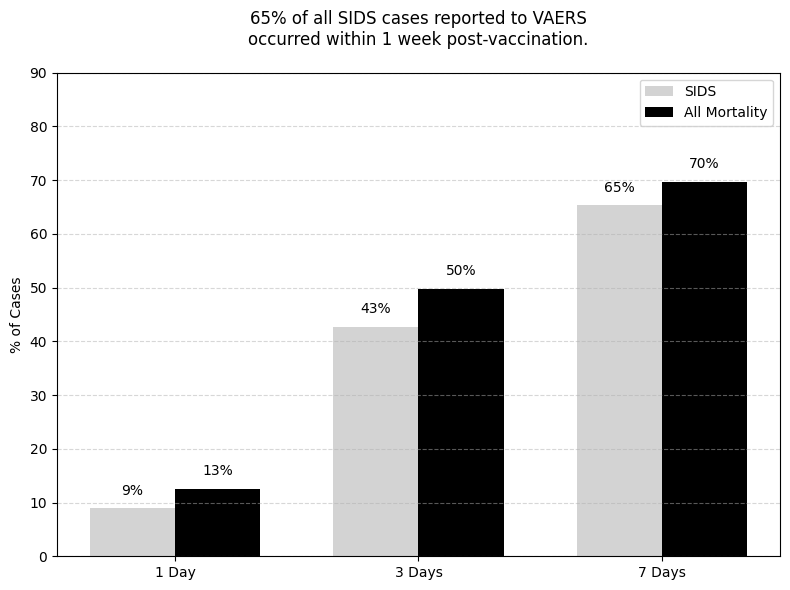

In [101]:
import matplotlib.pyplot as plt
import pandas as pd

# Helper function
def compute_percentages(df, day_column='DELTA_DAYS', thresholds=[0, 2, 6]):
    total = len(df)
    percentages = []
    for t in thresholds:
        count = (df[day_column] <= t).sum()
        pct = round((count / total) * 100, 1) if total > 0 else 0
        percentages.append(pct)
    return percentages

# Data
sids_percentages = compute_percentages(matches)
all_percentages = compute_percentages(df_died_1_d_all)

# Plot setup
days = ['1 Day', '3 Days', '7 Days']
x = range(len(days))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

# Bars
sids_bars = ax.bar([i - bar_width/2 for i in x], sids_percentages, width=bar_width, label='SIDS', color='lightgray')
all_bars  = ax.bar([i + bar_width/2 for i in x], all_percentages, width=bar_width, label='All Mortality', color='black')

# Add percentage labels on top
for bar_group in [sids_bars, all_bars]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 2, f'{height:.0f}%', ha='center', va='bottom', fontsize=10)

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.set_ylim(0, 90)
ax.set_ylabel('% of Cases')
ax.set_title('65% of all SIDS cases reported to VAERS\noccurred within 1 week post-vaccination.', pad=20)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


According to the paper, male infants are at more risk, and younger than 6 months babies are at more risk as well. For more info and the reasons behind these statements please refer to the explanation in the Discussion section.

In one of the references, Torch found that unvaccinated babies who died from SIDS did so most often in the fall or winter while vaccinated babies died most often at 2 and 4 months—the same ages when infants received their initial doses of DPT.

In another code in the current folder, we look at the vaccine types that have caused the highest mortalities using the RAG system with LLMs. Please check them out.

# More analysis (besides the paper) for the entire data 1990 - 2025

Now we look at the full data from 1990 to 2025 (instead of 1990 - 2019 in the paper).

In [102]:
adverse_2025 = adverse.copy()
adverse_2025['VAX_DATE_DATE'] = pd.to_datetime(adverse_2025['VAX_DATE'], errors='coerce')
adverse_2025['VAX_YEAR'] = adverse_2025['VAX_DATE_DATE'].dt.year
adverse_2025 = adverse_2025.copy()
adverse_2025['VAX_DATE_d'] = pd.to_datetime(adverse_2025['VAX_DATE'])
adverse_2025['ONSET_DATE_d'] = pd.to_datetime(adverse_2025['ONSET_DATE'])
adverse_2025['DURATION'] = adverse_2025['ONSET_DATE_d'] - adverse_2025['VAX_DATE_d']
adverse_2025 ['DELTA_DAYS'] = adverse_2025['DURATION'].dt.days
adverse_2025_1 = adverse_2025[adverse_2025.AGE_YRS<=1]
length_all_died = len(adverse_2025_1[adverse_2025_1['DIED']=='Y'])
print('\n')
print('Total number of reported injuries for infants less than 1 year old in 1990-2025:' , f'{len(adverse_2025_1)}')

under1_rate = round(adverse_2025_1.notna().sum()['DIED'] / adverse_2025_1.notna().sum()['VAERS_ID'] * 100, 2)
print('Total number of deaths from those injuries:' , f'{length_all_died}',', which is about ' f'{under1_rate}%')



Total number of reported injuries for infants less than 1 year old in 1990-2025: 85561
Total number of deaths from those injuries: 3021 , which is about 3.53%


In the stats below, the death, hospitalization, and disability rates are calculated for patients of all ages as well as infants less than 12 months old.

We observe that the death and hospitalization rates are higher for infants less than 12 months old compared to all ages. The disability rate is relatively the same.

In [103]:
print('Out of all ages and all of the data from 1990 to 2025:\n')
outcomes = ['DIED', 'HOSPITAL', 'DISABLE']
labels = {
    'DIED': 'Death rate',
    'HOSPITAL': 'Hospitalization rate',
    'DISABLE': 'Disability rate'}
for outcome in outcomes:
    all_rate = round(adverse_2025.notna().sum()[outcome] / adverse_2025.notna().sum()['VAERS_ID'] * 100, 2)
    under1_rate = round(adverse_2025_1.notna().sum()[outcome] / adverse_2025_1.notna().sum()['VAERS_ID'] * 100, 2)

    print(f"{labels[outcome]} for all ages: {all_rate}%")
    print(f"{labels[outcome]} for infants 12 months old and younger: {under1_rate}%")
    print('\n')

Out of all ages and all of the data from 1990 to 2025:

Death rate for all ages: 1.41%
Death rate for infants 12 months old and younger: 3.53%


Hospitalization rate for all ages: 7.29%
Hospitalization rate for infants 12 months old and younger: 12.62%


Disability rate for all ages: 1.86%
Disability rate for infants 12 months old and younger: 2.02%




In [104]:
#check
#delta_days_died = adverse_2025_1[(adverse_2025_1['DIED']=='Y')& (adverse_2025_1['DELTA_DAYS']>0)].notna()['DELTA_DAYS'].dropna()
#delta_days_died = adverse_2025_1[(adverse_2025_1['DIED']=='Y')&(adverse_2025_1['DELTA_DAYS']>0)]['DELTA_DAYS'].dropna()
#print('If the adverse effects after vaccination lead to death, on average the death occurs on day '+ f'{round(delta_days_died.mean(),2)}' + ' for all infants 0-12 months old')
#percentage_all = round(len(adverse_2025[(adverse_2025['DIED'] == 'Y') & (adverse_2025['DELTA_DAYS']<1)])/len(adverse_2025[adverse_2025['DIED'] == 'Y'])*100,2)
#print('The percentage of deaths that happened on the vaccination day for all infants 0-12 months old is ' + f'{percentage_all}' + '%.')


We trim down the dataframe to work with columns that have the most data (reduce is from 43 columns to 19). So we remove sparse columns, but we keep the "DIED" and "DELTA_DAYS" columns regardless of their counts to be able to generate the data we need.


In [105]:
adverse_2025_1 = adverse_2025_1.copy()
print('Number of columns: ',len(adverse_2025_1.columns))
threshold = 0.90
keep_cols = (adverse_2025_1.notna().mean() >= threshold) | (adverse_2025_1.columns == 'DIED')| (adverse_2025_1.columns == 'DELTA_DAYS')
adverse_2025_1 = adverse_2025_1.loc[:, keep_cols].copy()
print('Columns reduced to: ',len(adverse_2025_1.columns))
#print(adverse_2025_1['RECOVD'].value_counts(dropna=False))

Number of columns:  43
Columns reduced to:  19


We plot the distribution of age and sex for all infants up to 12 months old (inclusive) that have reported to VAERS.

The age distribution is a multimodal distribution with multiple peaks (modes).

At what age(s) are the reports of adverse effects most frequent?

One-year followed by the 2-months old age (and 5-months as the third most frequent) since there are clear peaks around 0.2, 0.5, and 1.0 years. The data has clusters at these ages which reflects vaccination schedules (or reporting patterns) in VAERS data (aligning with common pediatric vaccine ages: 2 months, 4-6 months, 12 months).

And for the sex distribution, males are sightly more affected than females as mentioned earlier. The paper goes on to explain about it. Some reports don't have the sex mentioned so a small portion are unknown.

<Axes: title={'center': 'Histogram of Sex (up to one year old)'}, xlabel='SEX', ylabel='Count'>

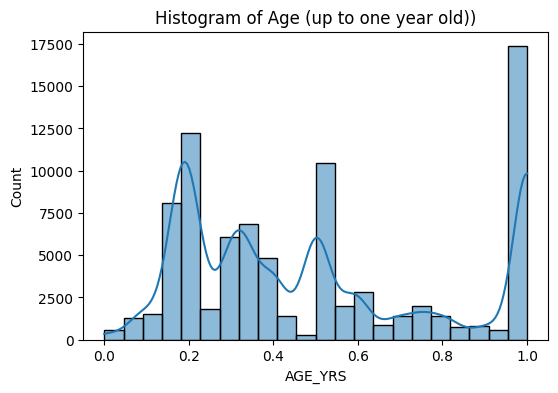

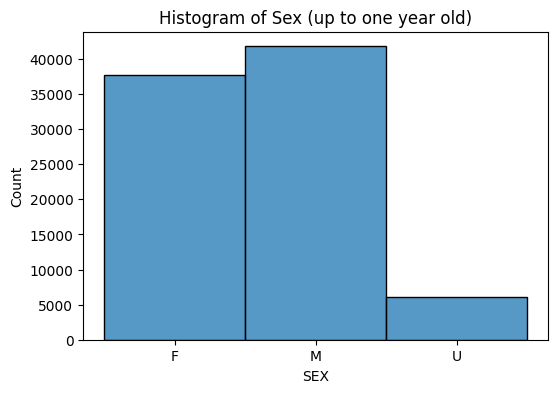

In [106]:
plt.figure(num=1, figsize=(6, 4))
plt.title('Histogram of Age (up to one year old))')
sns.histplot(data=adverse_2025_1, x='AGE_YRS', bins=22, kde=True)

plt.figure(num=2, figsize=(6, 4))
plt.title('Histogram of Sex (up to one year old)')
sns.histplot(data=adverse_2025_1, x='SEX')


#### Top two charts

We look at the duration (vaccination to symptoms onset period) versus age for up to 60 days.

Looking at the left chart, reports under 10 days have the most frequency, so we can take a more detailed look at the same chart for 10 days (right chart).

We also see that between the 0.2 (2 months) and 0.5 (5 months) marks, we have the longest stretches to 60 days. It is the same for the 1-year mark as well, but we focus more on the younger ages.

Putting these two plots next to each other, we see that the duration (days) is almost constant in the first 3 days (day 0 to 3 with day 0 being the vaccination day). This shows that most reports occur in temporal vicinity to vaccine administration suggesting that the vaccines are likely the reason for those symptoms.

#### Bottom two charts

If we look at the same charts with reported deaths included, we conclude the same as above: the deaths are clustered between the 1 and 5 month old marks with the first 3 days having the highest mortality rate.

We visibly see that there is a high mortality rate between 1 and 5 months (and  one year), "confirming that infant deaths tend to occur in temporal proximity to vaccine administration" as we saw in the conclusion of the paper.

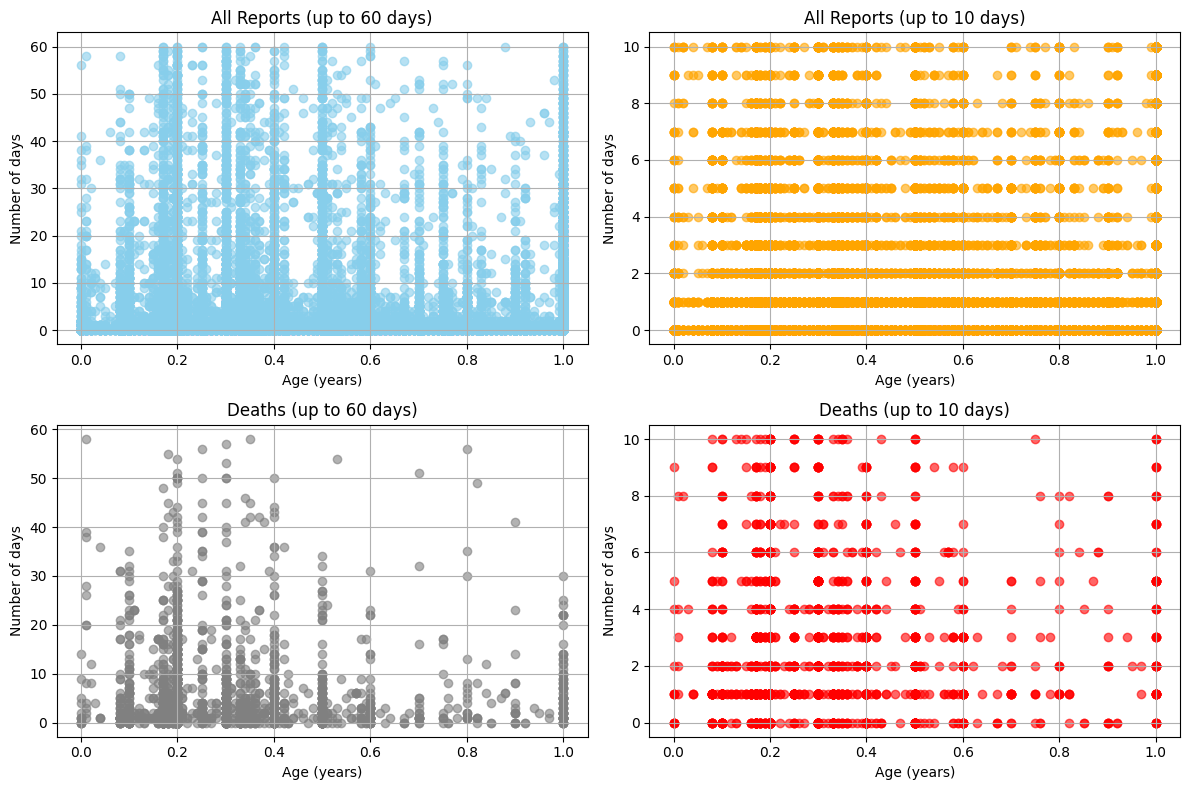

In [107]:
import matplotlib.pyplot as plt

# Create filtered DataFrames for All Reports
adverse_60 = adverse_2025_1[
    (adverse_2025_1['DELTA_DAYS'] >= 0) &
    (adverse_2025_1['DELTA_DAYS'] <= 60)
]

adverse_10 = adverse_2025_1[
    (adverse_2025_1['DELTA_DAYS'] >= 0) &
    (adverse_2025_1['DELTA_DAYS'] <= 10)
]

# Create filtered DataFrames for Deaths Only
adverse_60_death = adverse_2025_1[
    (adverse_2025_1['DELTA_DAYS'] >= 0) &
    (adverse_2025_1['DELTA_DAYS'] <= 60) &
    (adverse_2025_1['DIED'] == 'Y')
]

adverse_10_death = adverse_2025_1[
    (adverse_2025_1['DELTA_DAYS'] >= 0) &
    (adverse_2025_1['DELTA_DAYS'] <= 10) &
    (adverse_2025_1['DIED'] == 'Y')
]

# Set up 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)

# Top Left: All Reports up to 60 days
axs[0, 0].scatter(adverse_60['AGE_YRS'], adverse_60['DELTA_DAYS'], alpha=0.6, color='skyblue')
axs[0, 0].set_xlabel('Age (years)')
axs[0, 0].set_ylabel('Number of days')
axs[0, 0].set_title('All Reports (up to 60 days)')
axs[0, 0].grid(True)

# Top Right: All Reports up to 10 days
axs[0, 1].scatter(adverse_10['AGE_YRS'], adverse_10['DELTA_DAYS'], alpha=0.6, color='orange')
axs[0, 1].set_xlabel('Age (years)')
axs[0, 1].set_ylabel('Number of days')
axs[0, 1].set_title('All Reports (up to 10 days)')
axs[0, 1].grid(True)

# Bottom Left: Deaths Only up to 60 days
axs[1, 0].scatter(adverse_60_death['AGE_YRS'], adverse_60_death['DELTA_DAYS'], alpha=0.6, color='gray')
axs[1, 0].set_xlabel('Age (years)')
axs[1, 0].set_ylabel('Number of days')
axs[1, 0].set_title('Deaths (up to 60 days)')
axs[1, 0].grid(True)

# Bottom Right: Deaths Only up to 10 days
axs[1, 1].scatter(adverse_10_death['AGE_YRS'], adverse_10_death['DELTA_DAYS'], alpha=0.6, color='red')
axs[1, 1].set_xlabel('Age (years)')
axs[1, 1].set_ylabel('Number of days')
axs[1, 1].set_title('Deaths (up to 10 days)')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


Looking at the report frequency, we see that the 1-year mark has the highest count (17000+ cases, 20%) followed by the 2-month mark (11000+, 13%) out of all infants (up to one year old).

Looking at the same stats with deaths, we see that the 2 and 3 month old marks have the highest counts (31% and 11% respectively) suggesting the same conclusion: most deaths occur around the 2-month well baby visits.

Although the 12-month mark (1.00 year) gets the highest report counts, the death rate is way below all other infant ages (less than 3%), suggesting two possibilities: either the babies get stronger as they grow older or the vaccines around the 12-month are less lethal. Regardless of the cause, they get more symptoms to report to VAERS than any other age.

In [108]:
age_subsets = {
    'Adverse Reports': adverse_2025_1[adverse_2025_1['AGE_YRS'] <= 1]['AGE_YRS'],
    'Death Reports': adverse_2025_1[(adverse_2025_1['AGE_YRS'] <= 1) & (adverse_2025_1['DIED'] == 'Y')]['AGE_YRS']
}
# Loop through dictionary items
for label, age_subset in age_subsets.items():
    # Get counts and percentages
    counts = age_subset.value_counts().sort_index()
    percentages = age_subset.value_counts(normalize=True).sort_index() * 100

    # Combine into DataFrame
    summary = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(2)
    })
    print(f'\n{label} within the first year of age for all durations')
    print(summary.sort_values(by='Count', ascending=False).head(8))



Adverse Reports within the first year of age for all durations
         Count  Percentage
AGE_YRS                   
1.00     17141       20.03
0.20     11054       12.92
0.50      8727       10.20
0.17      6060        7.08
0.30      5829        6.81
0.33      4568        5.34
0.40      4101        4.79
0.60      2529        2.96

Death Reports within the first year of age for all durations
         Count  Percentage
AGE_YRS                   
0.20       929       30.75
0.30       341       11.29
0.17       221        7.32
0.40       195        6.45
0.50       169        5.59
0.10       121        4.01
0.25        98        3.24
1.00        96        3.18


Let's look at the histogram of the duration (number of days between vaccination and symptoms onset day) for up to 60 days and 10 days.
The top two charts show that the day of vaccination is the most frequent day that the adverse effects were reported.

The bottom two charts show the same stats but with deaths reported. The deaths mostly occurred on the next day of the vaccinations.


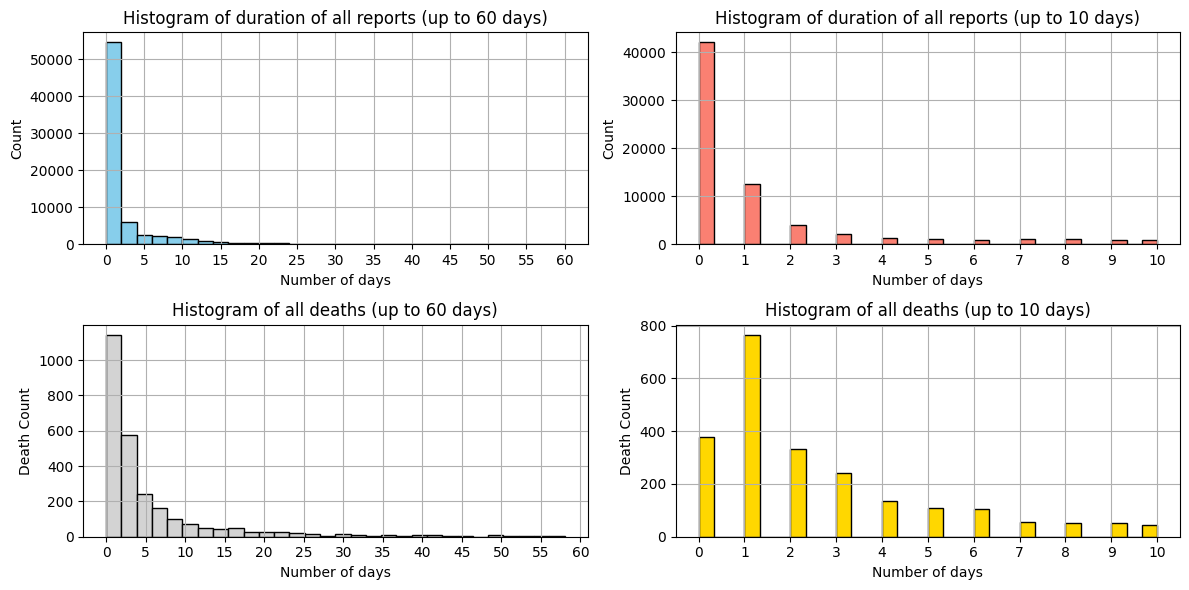

In [109]:
import matplotlib.pyplot as plt

# Set up 2 rows x 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# ==========================================================================================================================================
# Top Left: All cases up to 60 days
max_num_1 = 60
axs[0, 0].hist(
    adverse_2025_1[(adverse_2025_1['DELTA_DAYS'] < max_num_1 + 1) & (adverse_2025_1['DELTA_DAYS'] >= 0)]['DELTA_DAYS'],
    bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_xticks(range(0, max_num_1 + 1, 5))
axs[0, 0].set_xlabel('Number of days')
axs[0, 0].set_ylabel('Count')
#axs[0, 0].set_title(f'All Cases (up to {max_num_1} days)')
axs[0, 0].set_title('Histogram of duration of all reports (up to '+ f'{max_num_1}' + ' days)') #'Histogram of days between vaccination \n and symptoms offset date (up to 60 days)
axs[0, 0].grid(True)
# ==========================================================================================================================================
# Top Right: All cases up to 10 days
max_num_2 = 10
axs[0, 1].hist(
    adverse_2025_1[(adverse_2025_1['DELTA_DAYS'] < max_num_2 + 1) & (adverse_2025_1['DELTA_DAYS'] >= 0)]['DELTA_DAYS'],
    bins=30, color='salmon', edgecolor='black')
axs[0, 1].set_xticks(range(0, max_num_2 + 1, 1))
axs[0, 1].set_xlabel('Number of days')
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_title(f'Histogram of duration of all reports (up to {max_num_2} days)')
axs[0, 1].grid(True)

# ==========================================================================================================================================
# Bottom Left: Deaths up to 60 days
axs[1, 0].hist(
    adverse_2025_1[(adverse_2025_1['DELTA_DAYS'] < max_num_1 + 1) &
                   (adverse_2025_1['DELTA_DAYS'] >= 0) &
                   (adverse_2025_1['DIED'] == 'Y')]['DELTA_DAYS'],
    bins=30, color='lightgray', edgecolor='black')
axs[1, 0].set_xticks(range(0, max_num_1 + 1, 5))
axs[1, 0].set_xlabel('Number of days')
axs[1, 0].set_ylabel('Death Count')
axs[1, 0].set_title(f'Histogram of all deaths (up to {max_num_1} days)')
axs[1, 0].grid(True)

# ==========================================================================================================================================
# Bottom Right: Deaths up to 10 days
axs[1, 1].hist(
    adverse_2025_1[(adverse_2025_1['DELTA_DAYS'] < max_num_2 + 1) &
                   (adverse_2025_1['DELTA_DAYS'] >= 0) &
                   (adverse_2025_1['DIED'] == 'Y')]['DELTA_DAYS'],
    bins=30, color='gold', edgecolor='black')
axs[1, 1].set_xticks(range(0, max_num_2 + 1, 1))
axs[1, 1].set_xlabel('Number of days')
axs[1, 1].set_ylabel('Death Count')
axs[1, 1].set_title(f'Histogram of all deaths (up to {max_num_2} days)')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()




Now we focus on the first 10 days duration because it helps us visualize if there is a correlation between vaccination and reported symptoms onset date (and death).

### Age distribution (top left pie chart):

The ages that are most affected are 0-2 months having the highest percentage of reported symptoms. This pie chart is showing that in the first 10 days of vaccination, reported adverse effects have similar counts in almost all ages of 0-12 months with 0-2 being the highest followed by 2-4 months.

### Distribution of reports by Day (0-6) (top right pie chart):

The majority of the reported cases are on the day of the vaccination (66%)followed by the next day reports (20%) which is consistent with previous results.


### Age Distribution of deaths (bottom left pie chart):

The highest number of deaths occurred among the 0-2 month old infants (51%) followed by the 2-4 months infants (31%).


### Distribution of deaths by Day (0-6) (bottom right pie chart):
The highest number of deaths occurred mostly on the day of the vaccination (18%) and on the day after vaccination (37%).


From the above results we conclude that for most of the cases, the symptoms onset are reported on the day of the vaccination. If the infant dies as a result of the adverse effects of the vaccine, it is usually on the next day of the vaccination, and the most affected age group is the 0-2 months old infants. In order to know which specific vaccines contribute to these deaths, check out the other code that is using the RAG system with LLMs.  

In [110]:
#------ up to 10 days -------------------
max_delta_days = 10
adverse_2025_1 = adverse_2025_1[
    (adverse_2025_1['DELTA_DAYS'] >= 0) &
    (adverse_2025_1['DELTA_DAYS'] <= max_delta_days) ]
#----------------------------------------

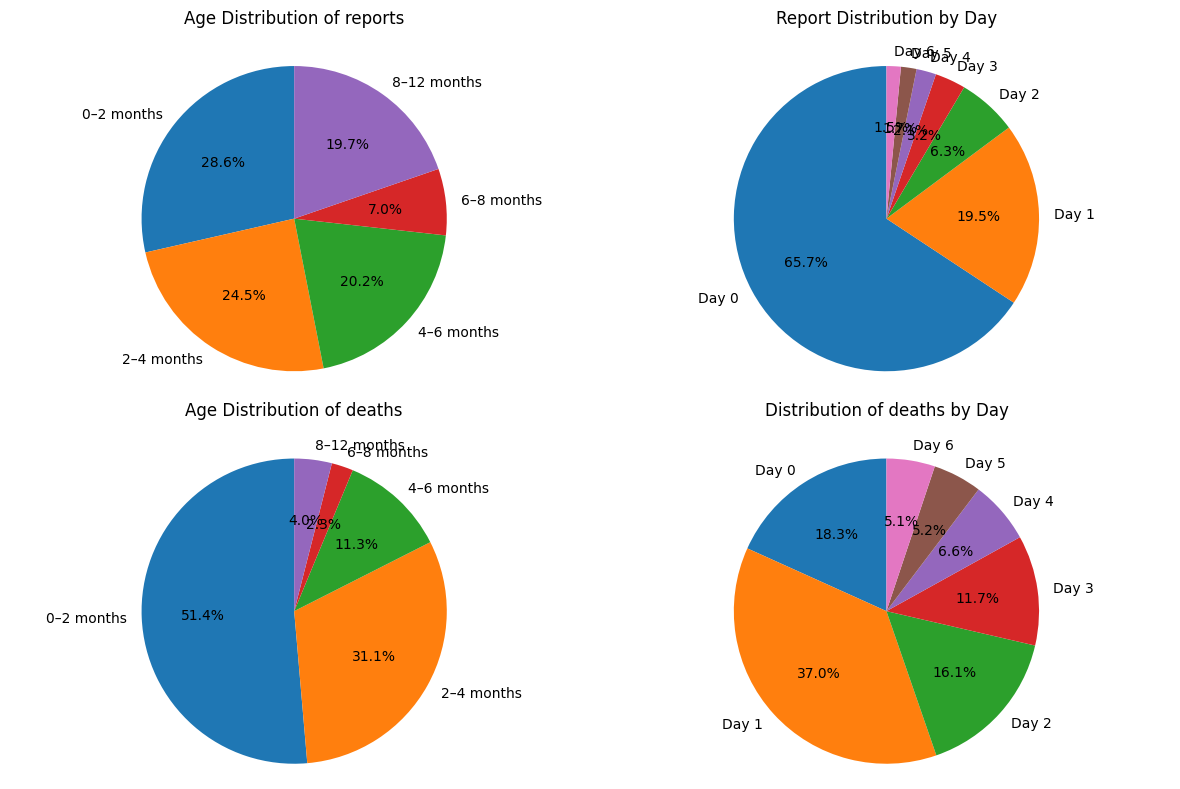

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

#for pd.cut(...), the bins have the following ranges:
#e.g. (a, b] → excludes the left edge, includes the right, with the exception that the first bin includes the 0.0 values.


# ----- Age Distribution for All Reports -----
age_bins_range = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
age_labels = ['0–2 months', '2–4 months', '4–6 months', '6–8 months', '8–12 months']
age_bins_all = pd.cut(adverse_2025_1['AGE_YRS'], bins=age_bins_range, labels=age_labels, include_lowest=True)
age_distribution_all = age_bins_all.value_counts().sort_index() # Count how many entries are in each bin

# ----- Day Distribution for All Reports -----
day_bins_range = list(range(0, 8))  # 0 to 7 (7 edges = 6 bins)
day_labels = [f'Day {i}' for i in range(0, 7)]
day_bins_all = pd.cut(adverse_2025_1['DELTA_DAYS'], bins=day_bins_range, labels=day_labels, right=False, include_lowest=True)
day_distribution_all = day_bins_all.value_counts().sort_index()

# ----- Age Distribution for Deaths Only -----
adverse_deaths = adverse_2025_1[adverse_2025_1['DIED'] == 'Y']
age_bins_death = pd.cut(adverse_deaths['AGE_YRS'], bins=age_bins_range, labels=age_labels, include_lowest=True)
age_distribution_death = age_bins_death.value_counts().sort_index()

# ----- Day Distribution for Deaths Only -----
day_bins_death = pd.cut(adverse_deaths['DELTA_DAYS'], bins=day_bins_range, labels=day_labels, right=False, include_lowest=True)
day_distribution_death = day_bins_death.value_counts().sort_index()

# ----- Plot 2x2 Pie Charts -----
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Top Left: Age Distribution All
axs[0, 0].pie(age_distribution_all, labels=age_distribution_all.index, autopct='%1.1f%%', startangle=90)
axs[0, 0].set_title('Age Distribution of reports', pad=20)
axs[0, 0].axis('equal')
axs[0, 0].grid(False)

# Top Right: Day Distribution All
axs[0, 1].pie(day_distribution_all, labels=day_distribution_all.index, autopct='%1.1f%%', startangle=90)
axs[0, 1].set_title('Report Distribution by Day', pad=20)
axs[0, 1].axis('equal')
axs[0, 1].grid(False)

# Bottom Left: Age Distribution Deaths Only
axs[1, 0].pie(age_distribution_death, labels=age_distribution_death.index, autopct='%1.1f%%', startangle=90)
axs[1, 0].set_title('Age Distribution of deaths', pad=20)
axs[1, 0].axis('equal')
axs[1, 0].grid(False)

# Bottom Right: Day Distribution Deaths Only
axs[1, 1].pie(day_distribution_death, labels=day_distribution_death.index, autopct='%1.1f%%', startangle=90)
axs[1, 1].set_title('Distribution of deaths by Day', pad=20)
axs[1, 1].axis('equal')
axs[1, 1].grid(False)

plt.tight_layout()
plt.show()
